In [1]:
# import model
import torch
import torch.nn as nn


### Dense Spiking

In [2]:
def call_spiking(tj, W, D_i, t_min, t_max, noise, dtype=torch.FloatTensor):
    """
    Calculates spiking times to recover ReLU-like functionality.
    Assumes tau_c=1 and B_i^(n)=1.
    """
    # Calculate the spiking threshold (Eq. 18)
    threshold = t_max - t_min - D_i
    
    # Calculate output spiking time ti (Eq. 7)

    ti = torch.matmul((tj - t_min).type(dtype), W.type(dtype)) + threshold + t_min
    
    # Ensure valid spiking time: do not spike for ti >= t_max
    ti = torch.where(ti < t_max, ti, t_max)

    # Add noise to the spiking time for noise simulations
    if noise > 0:
        ti = ti + torch.randn_like(ti) * noise
    
    return ti




In [3]:
class SpikingDense(nn.Module):
    def __init__(self, units, name, X_n=1, outputLayer=False, robustness_params={}, input_dim=None,
                 kernel_regularizer=None, kernel_initializer=None):
        super().__init__()
        self.units = units
        self.B_n = (1 + 0.0) * X_n
        self.outputLayer=outputLayer
        self.t_min_prev, self.t_min, self.t_max=0, 0, 1
        self.noise=robustness_params['noise']
        self.time_bits=robustness_params['time_bits']
        self.weight_bits =robustness_params['weight_bits'] 
        self.w_min, self.w_max=-1.0, 1.0
        self.alpha = torch.full((units,), 1, dtype=torch.float64)
        self.input_dim=input_dim
        self.regularizer = kernel_regularizer
        self.initializer = kernel_initializer
        self.bias = False
    
    def build(self, input_dim, kernel : torch.Tensor = None, bias : torch.Tensor = None):
        # Ensure input_dim is defined properly if not passed.
        if input_dim[-1] is None:
            input_dim = (None, self.input_dim)
        else:
            self.input_dim = input_dim
        # Create kernel weights and D_i.
        if kernel is not None:
            if bias is None:
                self.kernel = nn.Parameter(kernel.clone())
            else:
                self.kernel = nn.Parameter(torch.concat((kernel.clone(),bias.clone().unsqueeze(0))))
                self.bias = True
        else:
            self.kernel = nn.Parameter(torch.empty(input_dim[-1], self.units))
        self.D_i = nn.Parameter(torch.zeros(self.units))

        # Apply the initializer if provided.
        if self.initializer:
            self.kernel = self.initializer(self.kernel) # tu zmiana TODO

    def set_params(self, t_min_prev, t_min):
        """
        Set t_min_prev, t_min, t_max parameters of this layer. Alpha is fixed at 1.
        """
        max_W = torch.maximum(self.kernel,torch.zeros(self.kernel.shape))
        if self.bias:
            max_input = torch.concat(((t_min - t_min_prev) * torch.ones(self.input_dim), torch.tensor([(1)])))
        else:
            max_input = (t_min - t_min_prev) * torch.ones(self.input_dim)
        max_V = torch.max(torch.matmul(max_input,max_W))

        self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
        self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
        self.t_max = torch.tensor(t_min + self.B_n*max_V, dtype=torch.float64, requires_grad=False)

        
        # Returning for function signature consistency
        return t_min, t_min + self.B_n*max_V
    
    def forward(self, tj):
        """
        Input spiking times `tj`, output spiking times `ti` or membrane potential value for the output layer.
        """
        # Call the custom spiking logic
        if self.bias:
            print(tj.shape)
            new_tj = torch.concat((tj, torch.tensor([[(self.t_min - 1)]])), dim=1)
            output = call_spiking(new_tj, self.kernel, self.D_i, self.t_min, self.t_max, noise=self.noise)
        else:
            output = call_spiking(tj, self.kernel, self.D_i, self.t_min, self.t_max, noise=self.noise)
        # If this is the output layer, perform the special integration logic
        if self.outputLayer:
            # Compute weighted product
            W_mult_x = torch.matmul(self.t_min - tj, self.kernel)
            self.alpha = self.D_i / (self.t_min - self.t_min_prev)
            output = self.alpha * (self.t_min - self.t_min_prev) + W_mult_x

        return output

In [4]:
robustness_params={
    'noise':0.0,
    'time_bits':0,
    'weight_bits': 0,
    'latency_quantiles':0.0
}

spiking_dense = SpikingDense(4,"test",robustness_params=robustness_params)
weights = torch.rand(6,4,dtype=torch.float32)
spiking_dense.build((6,),weights)
t_min, t_max = spiking_dense.set_params(1,2)
print(t_min, t_max)

2 tensor(5.0893, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\1706425233.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(t_min + self.B_n*max_V, dtype=torch.float64, requires_grad=False)


In [5]:

t_input = torch.tensor([1,0,1,0,1,1],dtype=torch.float32)+1
inputs= 2 - t_input
linear_troch = torch.nn.Linear(6,4, bias=False)
linear_troch.weight = nn.parameter.Parameter(weights.T)
gtruth = linear_troch(inputs)
print(max(spiking_dense.t_max - spiking_dense(t_input)- gtruth).data)

tensor(5.9605e-08)


### Spiking Conv2D

In [6]:
class SpikingConv2D(nn.Module):
    def __init__(self, filters, name, X_n=1, padding='same', kernel_size=(3,3), robustness_params=None, kernels = None, device = 'cuda:0', biases = None, stride=1):
        super(SpikingConv2D, self).__init__()
        self.stride = stride
        if robustness_params is None:
            robustness_params = {}
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.B_n = (1 + 0.0) * X_n
        self.t_min_prev, self.t_min, self.t_max = 0, 0, 1
        self.w_min, self.w_max = -1.0, 1.0
        self.time_bits = robustness_params.get('time_bits', 1)
        self.weight_bits = robustness_params.get('weight_bits', 1) 
        self.noise = robustness_params.get('noise', 0.0)
        self.device = device
        # Initialize alpha as a tensor of ones
        self.alpha = nn.Parameter(torch.ones(filters, dtype=torch.float32))
        
        # Registering the kernel as a learnable parameter
        #TODO:
        if kernels is not None:
            self.kernel = nn.Parameter(kernels).to(device)
        else:
            self.kernel = nn.Parameter(torch.randn(filters, 1, kernel_size[0], kernel_size[1], dtype=torch.float32)).to(device)
        if biases is not None:
            self.B = biases.unsqueeze(1).to(self.device)
        else:
            self.B = nn.Parameter(torch.zeros(filters, 1, dtype=torch.float32)).to(self.device)

        # Placeholder for batch normalization parameters
        self.BN = nn.Parameter(torch.tensor([0], dtype=torch.float32), requires_grad=False)
        self.BN_before_ReLU = nn.Parameter(torch.tensor([0], dtype=torch.float32), requires_grad=False)
        
        # Parameter for different thresholds
        self.D_i = nn.Parameter(torch.zeros(9, filters, dtype=torch.float32)).to(self.device)

    def set_params(self, t_min_prev, t_min, minimal_t_max = 0):
        """
        Set t_min_prev, t_min, t_max, J_ij (kernel) and vartheta_i (threshold) parameters of this layer.
        """
        max_W = torch.maximum(self.kernel,torch.zeros(self.kernel.shape).to(self.device))
        max_input = (t_min - t_min_prev) * torch.ones(self.kernel.shape).to(self.device)
        if self.B is not None:
            max_V = torch.max(torch.sum(torch.mul(max_input,max_W),(1,2,3)) + self.B.unsqueeze(dim=1))
        else:
            max_V = torch.max(torch.sum(torch.mul(max_input,max_W),(1,2,3)))
        self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
        self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
        self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)

        
        # Returning for function signature consistency
        return t_min, max(t_min + self.B_n*max_V, minimal_t_max)

    def call_spiking(self, tj, W, D_i, t_min, t_max, noise):
        """
        Calculates spiking times from which ReLU functionality can be recovered.
        """
        threshold = t_max - t_min - D_i
        
        # Calculate output spiking time ti
        ti = torch.matmul(tj - t_min, W) + threshold + t_min
        
        # Ensure valid spiking time
        ti = torch.where(ti < t_max, ti, t_max)
        
        # Add noise
        if noise > 0:
            ti += torch.randn_like(ti) * noise
        
        return ti

    def forward(self, tj):
        """
        Input spiking times tj, output spiking times ti. 
        """
        if self.stride==1:
            padding_size = int(self.padding == 'same') * ((self.kernel_size[0]-1) // 2)
        else:
            # dont know if it works with stride other than 1 always set padding to valid
            padding_size = int(self.padding == 'same') * ((self.kernel_size[0]-1) // 2)
        image_same_size = tj.size(2) 
        image_valid_size = image_same_size - self.kernel_size[0] + 1
        
        # # Pad input with t_min value, equivalent to 0 in ReLU network
        # tj = torch.nn.functional.pad(tj.permute((1,2,0)), (0, 0, padding_size, padding_size, padding_size, padding_size), value=self.t_min).permute((2,0,1))
        
        # # Extract image patches
        # tj = torch.nn.functional.unfold(tj.unsqueeze(0), kernel_size=self.kernel_size, stride=1).permute(0, 2, 1).contiguous()
        
        # # Reshape kernel for fully connected behavior
        # W = self.kernel.view(-1, self.filters)

        tj_shape = tj.shape
        # Dodanie paddingu
        if self.padding == 'same':
            tj = torch.nn.functional.pad(tj, (padding_size, padding_size, padding_size, padding_size), value=self.t_min)
        elif type(self.padding) is tuple:
            tj = torch.nn.functional.pad(tj, (self.padding[0], self.padding[0], self.padding[1], self.padding[1]), value=self.t_min)
            pass
        # Wyciąganie patchy
        if self.stride==1:
            batch_size, in_channels, input_height, input_width = tj.shape
            tj = torch.nn.functional.unfold(tj, kernel_size=self.kernel_size, stride=1).transpose(1, 2)
            # Reshape dla wag
            W = self.kernel.view(self.filters, -1).t()
            out_channels, _, kernel_height, kernel_width = self.kernel.shape
            output_height = (input_height - kernel_height) // self.stride + 1
            output_width = (input_width - kernel_width) // self.stride + 1
        else:
            batch_size, in_channels, input_height, input_width = tj.shape
            tj = torch.nn.functional.unfold(tj, kernel_size=self.kernel_size, stride=self.stride).transpose(1, 2)
            out_channels, _, kernel_height, kernel_width = self.kernel.shape
            output_height = (input_height - kernel_height) // self.stride + 1
            output_width = (input_width - kernel_width) // self.stride + 1
            # Reshape dla wag
            W = self.kernel.view(out_channels, -1).t()
        
        
        
        if (self.padding == 'valid' or self.BN != 1 or self.BN_before_ReLU == 1) and (self.B is None): 
            # tj = tj.view(-1, W.size(0))
            ti = self.call_spiking(tj, W, self.D_i[0], self.t_min, self.t_max, noise=self.noise).transpose(1, 2)
            if self.padding == 'valid':
                # ti = ti.view(-1, image_valid_size, image_valid_size, self.filters)
                ti = ti.view(batch_size, out_channels, output_height, output_width)
                #ti = torch.nn.functional.fold(ti, (tj_shape[-1],tj_shape[-1]), (1, 1)) #assuming square input
            else:
                ti = ti.view(batch_size, out_channels, output_height, output_width)
                #ti = torch.nn.functional.fold(ti, (tj_shape[-1],tj_shape[-1]), (1, 1)) #assuming square input
                # ti = ti.view(-1, image_same_size, image_same_size, self.filters)
        elif self.B is not None:
            ## concatenating simple "one" to vector of times
            one_as_time = self.t_min - 1
            tj = torch.concat((tj, one_as_time * torch.ones(tj.shape[0],tj.shape[1],1).to(self.device)), 2)
            ## conttenating biases to weight vector
            W = torch.concat((W,self.B.T),0)
            ti = self.call_spiking(tj, W, self.D_i[0], self.t_min, self.t_max, noise=self.noise).transpose(1, 2)
            if self.padding == 'valid':
                # ti = ti.view(-1, image_valid_size, image_valid_size, self.filters)
                # ti = torch.nn.functional.fold(ti, (tj_shape[-1],tj_shape[-1]), (1, 1)) #assuming square input
                ti = ti.view(batch_size, out_channels, output_height, output_width)
            else:
                # ti = torch.nn.functional.fold(ti, (tj_shape[-1],tj_shape[-1]), (1, 1)) #assuming square input
                ti = ti.view(batch_size, out_channels, output_height, output_width)
                # ti = ti.view(-1, image_same_size, image_same_size, self.filters)

        # else:
        #     # Partition the input for different thresholds
        #     tj_partitioned = [
        #         tj[:, 1:-1, 1:-1], 
        #         tj[:, :1, :1], 
        #         tj[:, :1, 1:-1], 
        #         tj[:, :1, -1:], 
        #         tj[:, 1:-1, -1:], 
        #         tj[:, -1:, -1:], 
        #         tj[:, -1:, 1:-1], 
        #         tj[:, -1:, :1], 
        #         tj[:, 1:-1, :1]
        #     ]
        #     ti_partitioned = []

        #     for i, tj_part in enumerate(tj_partitioned):
        #         tj_part = tj_part.view(-1, W.size(0))
        #         ti_part = self.call_spiking(tj_part, W, self.D_i[i], self.t_min, self.t_max, noise=self.noise)
                
        #         # Reshape partitions
        #         if i == 0: 
        #             ti_part = ti_part.view(-1, image_valid_size, image_valid_size, self.filters)
        #         if i in [1, 3, 5, 7]: 
        #             ti_part = ti_part.view(-1, 1, 1, self.filters)
        #         if i in [2, 6]: 
        #             ti_part = ti_part.view(-1, 1, image_valid_size, self.filters)
        #         if i in [4, 8]: 
        #             ti_part = ti_part.view(-1, image_valid_size, 1, self.filters)
        #         ti_partitioned.append(ti_part) 

        #     # Concatenate to create a complete output
        #     if image_valid_size != 0:
        #         ti_top_row = torch.cat([ti_partitioned[1], ti_partitioned[2], ti_partitioned[3]], dim=2)
        #         ti_middle = torch.cat([ti_partitioned[8], ti_partitioned[0], ti_partitioned[4]], dim=2)
        #         ti_bottom_row = torch.cat([ti_partitioned[7], ti_partitioned[6], ti_partitioned[5]], dim=2)
        #         ti = torch.cat([ti_top_row, ti_middle, ti_bottom_row], dim=1)         
        #     else:
        #         ti_top_row = torch.cat([ti_partitioned[1], ti_partitioned[3]], dim=2)
        #         ti_bottom_row = torch.cat([ti_partitioned[7], ti_partitioned[5]], dim=2)
        #         ti = torch.cat([ti_top_row, ti_bottom_row], dim=1)

        return ti

In [7]:
robustness_params={
    'noise':0.0,
    'time_bits':0,
    'weight_bits': 0,
    'latency_quantiles':0.0
}

spiking_conv2 = SpikingConv2D(4,"test",robustness_params=robustness_params, device='cpu')
weights = torch.ones((6,4),dtype=torch.float32)
t_min, t_max = spiking_conv2.set_params(0,1)

C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)


In [8]:
t_input = torch.tensor([[[1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1]]],dtype=torch.float32).unsqueeze(0)
print(t_input.shape)
print(spiking_conv2.t_max - spiking_conv2(t_input))
print(spiking_conv2(t_input).shape)

torch.Size([1, 1, 7, 7])
tensor([[[[0.0000, 1.5698, 1.4425, 2.8032, 1.4425, 1.2334, 0.0000],
          [0.0000, 0.7673, 2.0175, 2.8659, 2.0175, 2.0986, 0.0000],
          [0.0000, 0.7673, 2.0175, 2.8659, 2.0175, 2.0986, 0.0000],
          [0.0000, 0.7673, 2.0175, 2.8659, 2.0175, 2.0986, 0.0000],
          [0.0000, 0.7673, 2.0175, 2.8659, 2.0175, 2.0986, 0.0000],
          [0.0000, 0.7673, 2.0175, 2.8659, 2.0175, 2.0986, 0.0000],
          [0.0000, 0.2570, 1.5047, 2.9200, 1.5047, 2.6630, 0.0000]],

         [[0.0000, 0.0000, 2.2379, 0.0000, 2.2379, 0.0465, 0.0000],
          [0.0000, 0.0000, 1.7205, 0.0000, 1.7205, 1.1788, 0.0000],
          [0.0000, 0.0000, 1.7205, 0.0000, 1.7205, 1.1788, 0.0000],
          [0.0000, 0.0000, 1.7205, 0.0000, 1.7205, 1.1788, 0.0000],
          [0.0000, 0.0000, 1.7205, 0.0000, 1.7205, 1.1788, 0.0000],
          [0.0000, 0.0000, 1.7205, 0.0000, 1.7205, 1.1788, 0.0000],
          [0.0000, 0.0000, 0.8477, 0.0000, 0.8477, 0.9717, 0.0000]],

         [[0.0000, 

In [9]:
from torchvision.models import resnet50, ResNet50_Weights
class ResNet(nn.Module):
    def __init__(self, num_classes = 2):
        super(ResNet, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.model.conv1 = nn.Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)
        self.model.to("cuda")


    def forward(self, x):
        return self.model.forward(x)

In [10]:
model = torch.load("best_resnet50_MINST-DVS.pt", weights_only=False)
model = ResNet(10).to('cuda:0')
model.model.load_state_dict(torch.load("best_resnet50_MINST-DVS.pt", weights_only=True))
model.eval()

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ResNet(
  (model): ResNet(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [11]:
print(model.model.layer1[0].conv3.weight.data.shape)

torch.Size([256, 64, 1, 1])


In [12]:
spiking_conv2 = SpikingConv2D(256,"test2",robustness_params=robustness_params,kernels=model.model.layer1[0].conv3.weight.data,kernel_size=(1,1))
t_min, t_max = spiking_conv2.set_params(0,1)

C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)


In [13]:
t_input = torch.tensor(64*[[[1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1],
                        [1,1,0,1,0,1,1]]],dtype=torch.float32)
print(t_input.shape)

torch.Size([64, 7, 7])


In [14]:
conv2d = model.model.layer1[0].conv3
t_input_x = 1-t_input
x_torch = nn.ReLU()(conv2d(t_input_x.to("cuda")))

In [15]:
x_torch.shape

torch.Size([256, 7, 7])

In [16]:
out = spiking_conv2(t_input.unsqueeze(0).to("cuda"))
x_ttfs = spiking_conv2.t_max-out
x_ttfs.shape

torch.Size([1, 256, 7, 7])

In [17]:
out = spiking_conv2(t_input.unsqueeze(0).to("cuda"))
x_ttfs = (spiking_conv2.t_max-out)
print(x_ttfs.shape)

torch.Size([1, 256, 7, 7])


In [18]:
# print(x_ttfs.squeeze(0)[0])
# print(x_torch.permute(1, 2, 0)[0])
print((x_ttfs.squeeze(0)-x_torch).abs().max())

tensor(8.9407e-08, device='cuda:0', grad_fn=<MaxBackward1>)


In [19]:
inp = 1-t_input
inp = inp.unsqueeze(0)
print(model.model.layer1[0].conv3)
kernel_size = (1,1)
padding_size = ((kernel_size[0] - 1) // 2)

inp = torch.nn.functional.pad(inp, (padding_size, padding_size, padding_size, padding_size), mode='constant', value=0)
w = model.model.layer1[0].conv3.weight.data.to("cpu")
print(w.shape)
inp_unf = torch.nn.functional.unfold(inp, kernel_size)
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
out = torch.nn.functional.fold(out_unf, (7,7), (1, 1))
print((torch.nn.functional.conv2d(inp, w) - out).abs().max())
inp = 1-t_input
inp = inp.unsqueeze(0)
out2 = model.model.layer1[0].conv3(inp.to("cuda:0"))
print(out.shape)
print(torch.nn.functional.conv2d(inp, w, stride=(1, 1), padding=(0,0)).shape)
print((out2.to("cpu") - torch.nn.functional.conv2d(inp, w, stride=(1, 1), padding=(0,0))).abs().max())
print((out2.to("cpu")).abs().max())
print((model.model.layer1[0].conv3(inp.to("cuda:0"))-torch.nn.functional.conv2d(inp, w, stride=(1, 1), padding=model.model.layer1[0].conv3.padding).to("cuda:0")).abs().max())
print()

Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
torch.Size([256, 64, 1, 1])
tensor(1.3970e-09)
torch.Size([1, 256, 7, 7])
torch.Size([1, 256, 7, 7])
tensor(5.9605e-08, grad_fn=<MaxBackward1>)
tensor(0.9145, grad_fn=<MaxBackward1>)
tensor(5.9605e-08, device='cuda:0', grad_fn=<MaxBackward1>)



In [20]:
import torch

conv_layer = model.model.layer1[0].conv2
w = conv_layer.weight
bias = conv_layer.bias

# Prepare input
inp = 1 - t_input
inp = inp.unsqueeze(0)

# Get the conv layer and parameters (bias is None)
conv_layer = model.model.layer1[0].conv2
w = conv_layer.weight.data.to("cpu")

# Manually apply padding for same padding (3x3 kernel, stride 1)
kernel_size = (3, 3)
padding_size = (kernel_size[0] - 1) // 2

# Apply padding to input manually
inp2 = torch.nn.functional.pad(inp, (padding_size, padding_size, padding_size, padding_size), mode='constant', value=0)

# Unfold input for manual convolution
inp_unf = torch.nn.functional.unfold(inp2, kernel_size)

# Perform the matrix multiplication with weights reshaped to unfold shape
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)

# Correctly reshape before folding, setting kernel size correctly as single-pixel patches
out_unf = out_unf.view(1, 64, 49)  # 64 output channels, 49 patches

# Calculate the correct output shape (7x7)
output_height, output_width = 7, 7

# Perform fold
out = torch.nn.functional.fold(out_unf, (output_height, output_width), kernel_size=(1, 1))

# Compare with torch.nn.functional.conv2d TODO: Tu zmieniać na CPU i GPU
out_conv2d = torch.nn.functional.conv2d(inp, conv_layer.weight.to('cpu'), padding=(1, 1)).to("cpu")
conv_layer = model.model.layer1[0].conv2
w = conv_layer.weight
bias = conv_layer.bias
# out_conv2d = torch.nn.functional.conv2d(inp.to("cuda:0"), w, padding=(1,1))
print(out.shape, out_conv2d.shape)


# Use the model's conv2 layer for comparison
conv_layer = model.model.layer1[0].conv2
out2 = conv_layer(inp.to("cuda:0"))


conv_layer = model.model.layer1[0].conv2
w = conv_layer.weight
bias = conv_layer.bias

out1 = conv_layer(inp.to("cuda:0"))
# out_conv2d = torch.nn.functional.conv2d(inp.to("cuda:0"), w, padding=(1,1))
print((out1 - out2.to("cuda:0")).abs().max())
print("Max difference (manual conv vs conv2d):", (out_conv2d.to("cpu") - out.to("cpu")).abs().max())
print("Max difference (model vs conv2d):", (out1.to("cpu") - out_conv2d.to("cpu")).abs().max())
print("Max absolute value (model output):", out2.abs().max())

# Compare manual and model convolutions directly
print("Max difference (manual vs model):", (out2.to("cpu") - out).abs().max())


torch.Size([1, 64, 7, 7]) torch.Size([1, 64, 7, 7])
tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
Max difference (manual conv vs conv2d): tensor(2.9802e-08, grad_fn=<MaxBackward1>)
Max difference (model vs conv2d): tensor(0.0001, grad_fn=<MaxBackward1>)
Max absolute value (model output): tensor(0.6116, device='cuda:0', grad_fn=<MaxBackward1>)
Max difference (manual vs model): tensor(0.0001, grad_fn=<MaxBackward1>)


In [21]:
conv_layer = model.model.layer1[0].conv2
w = conv_layer.weight
bias = conv_layer.bias

out1 = conv_layer(inp.to("cuda:0"))
out2 = torch.nn.functional.conv2d(inp.to("cuda:0"), w, padding=(1,1))
print((out1 - out2.to("cuda:0")).abs().max())

tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)


In [22]:
inp = torch.randn(1, 3, 10, 12)
w = torch.randn(2, 3, 4, 5)
inp_unf = torch.nn.functional.unfold(inp, (4, 5))
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
out = torch.nn.functional.fold(out_unf, (7, 8), (1, 1))
# or equivalently (and avoiding a copy),
out = out_unf.view(1, 2, 7, 8)
(torch.nn.functional.conv2d(inp, w) - out).abs().max()   

tensor(5.7220e-06)

### Fuse batch normalization + conv

In [23]:
def fuse_conv_and_bn(conv, bn, device = 'cuda:0'):
	#
	# init
	fusedconv = torch.nn.Conv2d(
		conv.in_channels,
		conv.out_channels,
		kernel_size=conv.kernel_size,
		stride=conv.stride,
		padding=conv.padding,
		bias=True
	)
	#
	# prepare filters
	w_conv = conv.weight.clone().view(conv.out_channels, -1)
	w_bn = torch.diag(bn.weight.div(torch.sqrt(bn.eps+bn.running_var)))
	with torch.no_grad():
		fusedconv.weight.copy_( torch.mm(w_bn, w_conv).view(fusedconv.weight.size()) )
	#
	# prepare spatial bias
	if conv.bias is not None:
		b_conv = conv.bias
	else:
		b_conv = torch.zeros( conv.weight.size(0) ).to(device)
	b_bn = bn.bias - bn.weight.mul(bn.running_mean).div(torch.sqrt(bn.running_var + bn.eps))
	with torch.no_grad():
		fusedconv.bias.copy_( (torch.matmul(w_bn, b_conv) + b_bn) )
	
	return fusedconv.to(device)

In [24]:
conv2d = model.model.layer1[0].conv3
bias_from_nn = model.model.layer1[0].bn3
bias_from_nn.eval()
net = torch.nn.Sequential(
	model.model.layer1[0].conv3,
	model.model.layer1[0].bn3,
    nn.ReLU()
)
net.eval()

Sequential(
  (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)

In [25]:
conv_fused = fuse_conv_and_bn(conv2d, bias_from_nn)

In [26]:
spiking_conv2 = SpikingConv2D(256,"test2",robustness_params=robustness_params,kernels=conv_fused.weight.data, biases=conv_fused.bias, kernel_size=(1,1))
t_min, t_max = spiking_conv2.set_params(0,1)



C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)


In [27]:
conv_fused.bias.shape

torch.Size([256])

In [28]:
out = spiking_conv2(t_input.unsqueeze(0).to("cuda"))
x_ttfs = (spiking_conv2.t_max-out)
print(x_ttfs.shape)

torch.Size([1, 256, 7, 7])


In [29]:
print(out.max())
print(out.min())

tensor(7.4907, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3.8831, device='cuda:0', grad_fn=<MinBackward1>)


In [30]:
t_input_x = 1-t_input
x_torch = (net(t_input_x.unsqueeze(0).to("cuda")))


In [31]:
print((x_ttfs.squeeze(0)-x_torch).abs().max())

tensor(9.5367e-07, device='cuda:0', grad_fn=<MaxBackward1>)


In [32]:
conv2d = model.model.layer1[0].conv3
bias_from_nn = model.model.layer1[0].bn3
bias_from_nn.eval()


inp = 1-t_input
inp = inp.unsqueeze(0).to("cuda:0")

kernel_size = (1,1)
padding_size = (kernel_size[0] // 2)

inp2 = torch.nn.functional.pad(inp, (padding_size, padding_size, padding_size, padding_size), value=0)
w = conv_fused.weight.data
inp_unf = torch.nn.functional.unfold(inp2, (1,1))
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
out = torch.nn.functional.fold(out_unf, (7,7), (1, 1))
out = out + conv_fused.bias.data.view(1, 256, 1, 1) 
print((torch.nn.functional.conv2d(inp, w, bias=conv_fused.bias, padding=(padding_size,padding_size)) - out).abs().max())

inp = 1-t_input
inp = inp.unsqueeze(0)
model.model.layer1[0].bn1.eval()
net2 = torch.nn.Sequential(
	model.model.layer1[0].conv3,
	model.model.layer1[0].bn3
)
out2 = net2(inp.to("cuda:0"))
print((out2 - out.to("cuda:0")).abs().max())
print((out2.to("cpu")).abs().max())



tensor(0., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(9.5367e-07, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(4.8420, grad_fn=<MaxBackward1>)


In [33]:
inp = torch.randn(1, 3, 10, 12)
w = torch.randn(2, 3, 4, 5)
inp_unf = torch.nn.functional.unfold(inp, (4, 5), stride=(2,2))
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
out = torch.nn.functional.fold(out_unf, (7, 8), (1, 1), stride=(2,2))
# or equivalently (and avoiding a copy),
# out = out_unf.view(1, 2, 7, 8)
print(out.shape)
print(torch.nn.functional.conv2d(inp, w,stride= (2,2), padding=(3,4)).shape)
(torch.nn.functional.conv2d(inp, w ,stride= (2,2), padding=(3,4)) - out)#.abs().max()

torch.Size([1, 2, 7, 8])
torch.Size([1, 2, 7, 8])


tensor([[[[  5.4809,  -2.7389,  -3.7882,   2.2093,  -7.7872,  -1.2644,   4.9757,
             1.7292],
          [  1.8345,  -4.8786,   3.3867,   8.9886,   2.9018,  -4.8675,   6.4918,
            -2.8426],
          [ -5.7101,   4.2118,  -5.6737,   3.9756, -13.9600,   2.1439,   9.3056,
            -3.7186],
          [ -2.4305,   6.8247,  -2.5439, -11.5840,  -0.2728,   7.4573,   9.6497,
             2.9581],
          [ -7.5298,   1.8119,   2.3664,   1.0599,   2.2424,  10.6940,   5.9245,
            -4.1176],
          [  4.2635,   3.0588,  -3.3941,   3.0237,  -0.8737,  -5.9769,  -2.0083,
            -0.8135],
          [ -4.9533,   1.0196,   5.6690,  -0.6195,  -2.5856,  -1.3279,   1.9264,
            -2.3364]],

         [[  1.5712,   0.5898,  -5.0947,  -3.3988,  -6.9160,  -4.6906,  -1.6789,
            -0.4998],
          [  3.5965,  -6.4140,   1.7303,   5.3076,  -1.4501,  -7.1534,   1.6064,
            -3.3670],
          [  9.7327,  -9.5707, -17.1044,   9.8836,  15.9195,  -0.3299, 

In [34]:
model = torch.load("best_resnet50_MINST-DVS.pt", weights_only=False)
model = ResNet(10).to('cuda:0')
model.model.load_state_dict(torch.load("best_resnet50_MINST-DVS.pt", weights_only=True))
model.eval()
inp = torch.randn(1, 5, 10, 12)
conv = model.model.conv1
print(conv(inp.to('cuda')).shape)

torch.Size([1, 64, 5, 6])


## Stride

In [35]:
import torch
import torch.nn.functional as F

def conv2d_stride(input_tensor, weight, bias=None, stride=2):
    # Wymiary wejściowego obrazu
    batch_size, in_channels, input_height, input_width = input_tensor.shape
    out_channels, _, kernel_height, kernel_width = weight.shape
    
    # Obliczanie wymiarów obrazu wyjściowego na podstawie stride
    output_height = (input_height - kernel_height) // stride + 1
    output_width = (input_width - kernel_width) // stride + 1
    
    # Rozwijanie obrazu do fragmentów (patches)
    unfolded_input = F.unfold(input_tensor, kernel_size=(kernel_height, kernel_width), stride=stride)
    
    # Mnożenie rozwiniętych fragmentów przez wagi
    unfolded_output = weight.view(out_channels, -1) @ unfolded_input
    if bias is not None:
        unfolded_output += bias.view(1, -1, 1)
    
    # Składanie wyników z powrotem do obrazu wyjściowego
    output_tensor = unfolded_output.view(batch_size, out_channels, output_height, output_width)
    
    return output_tensor

# Przykład użycia:
batch_size = 1
in_channels = 5
out_channels = 64
input_height = 7
input_width = 7
kernel_height = 7
kernel_width = 7

# Tworzymy przykładowe dane wejściowe i wagi
input_tensor = torch.randn(batch_size, in_channels, input_height, input_width)
weight = torch.randn(out_channels, in_channels, kernel_height, kernel_width)
bias = torch.randn(out_channels)

# Przeprowadzamy konwolucję
output_tensor1 = conv2d_stride(input_tensor, weight, bias)
print(output_tensor1.shape)  # Sprawdzamy wynikowy kształt

# Wykonanie konwolucji
output_tensor2 = F.conv2d(input_tensor, weight, bias, stride=2)
print(output_tensor2.shape)  # Sprawdzamy wynikowy kształt
print((output_tensor1-output_tensor2).abs().max())

torch.Size([1, 64, 1, 1])
torch.Size([1, 64, 1, 1])
tensor(1.5259e-05)


## Pierwsza konwolucja

In [36]:
model = torch.load("best_resnet50_MINST-DVS.pt", weights_only=False)
model = ResNet(10).to('cuda:0')
model.model.load_state_dict(torch.load("best_resnet50_MINST-DVS.pt", weights_only=True))
model.eval()

ResNet(
  (model): ResNet(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

In [37]:
spiking_conv2 = SpikingConv2D(64,"test2",padding=(3,3),robustness_params=robustness_params,kernels=model.model.conv1.weight.data,kernel_size=(7,7),stride=2)
t_min, t_max = spiking_conv2.set_params(0,1)

C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)


In [38]:
# t_input = torch.tensor(5*[[[1,1,0,1,0,1,1],
#                         [1,1,0,1,0,1,1],
#                         [1,1,0,1,0,1,1],
#                         [1,1,0,1,0,1,1],
#                         [1,1,0,1,0,1,1],
#                         [1,1,0,1,0,1,1],
#                         [1,1,0,1,0,1,1]]],dtype=torch.float32)
t_input = torch.rand(1,5,64,64)
print(t_input.shape)

torch.Size([1, 5, 64, 64])


In [39]:
conv2d = model.model.conv1

t_input_x = 1-t_input
x_torch = nn.ReLU()(conv2d(t_input_x.to("cuda")))

In [40]:
out = spiking_conv2(t_input.to("cuda"))
x_ttfs = spiking_conv2.t_max-out
x_ttfs.shape

torch.Size([1, 64, 32, 32])

In [41]:
print(x_torch.shape)
print(x_ttfs.squeeze(0).shape)


torch.Size([1, 64, 32, 32])
torch.Size([64, 32, 32])


In [42]:
print((x_ttfs.squeeze(0)-x_torch).abs().max())

tensor(1.7881e-06, device='cuda:0', grad_fn=<MaxBackward1>)


### Maxpool

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxMinPool2D(nn.Module):
    """
    Max Pooling or Min Pooling operation, depending on the sign of the batch normalization layer before.
    """
    def __init__(self, kernel_size, max_time, stride=None, padding=0, dilation=1):
        super(MaxMinPool2D, self).__init__()
        
        # Default sign is 1, indicating max pooling functionality.
        self.sign = nn.Parameter(-1*torch.ones(1, 1, 1, 1), requires_grad=False)
        self.dilation = dilation
        # MaxPool2d setup (will be used in call)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.max_time = max_time

    def forward(self, inputs):
        # Applying the sign to the inputs (if sign is -1, it will act as Min Pooling)
        padding_size = self.padding
        inputs = torch.nn.functional.pad(inputs, (padding_size, padding_size, padding_size, padding_size), value=self.max_time)
        pooled = F.max_pool2d(self.sign * inputs, kernel_size=self.kernel_size, stride=self.stride, padding=0, dilation=self.dilation)
        
        # Multiply the pooled result by the sign, which controls the pooling type
        return pooled * self.sign

In [44]:
pool = MaxMinPool2D(2,0)
inp2 = torch.nn.functional.pad(inp, (padding_size, padding_size, padding_size, padding_size), mode='constant', value=0)
print(inp2.shape)
pool(inp2).shape

torch.Size([1, 5, 10, 12])


torch.Size([1, 5, 5, 6])

### AdaptiveAvgPool (1,1)

In [45]:
import torch
import torch.nn as nn

class AvgPool2dToConv2d(nn.Module):
    def __init__(self, kernel_size=7):
        super(AvgPool2dToConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding=0, bias=False)
        
        # Initialize weights to simulate average pooling behavior
        with torch.no_grad():
            self.conv.weight.fill_(1.0 / (kernel_size * kernel_size))  # Fill the kernel with 1/49 to average over a 7x7 window

    def forward(self, x):
        return self.conv(x)

# Example usage:
model = AvgPool2dToConv2d().conv
avg_pool = nn.AvgPool2d(7, stride=1)
input_tensor = torch.randn(1, 1, 28, 28)  # Example input tensor of shape (batch_size, channels, height, width)
output = model(input_tensor)
output_avg_pool = avg_pool(input_tensor)
print(output.shape)
print(output_avg_pool.shape)
print(torch.abs(output - output_avg_pool).max())

torch.Size([1, 1, 22, 22])
torch.Size([1, 1, 22, 22])
tensor(1.1176e-07, grad_fn=<MaxBackward1>)


In [46]:
model = torch.load("best_resnet50_MINST-DVS.pt", weights_only=False)
model = ResNet(10).to('cuda:0')
model.model.load_state_dict(torch.load("best_resnet50_MINST-DVS.pt", weights_only=True))
model.eval()

ResNet(
  (model): ResNet(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

## Add Layer

In [47]:
class AddSNNLayer(nn.Module):
    def __init__(self):
        super(AddSNNLayer, self).__init__()
        self.noise = 0
        self.B_n = 1
        pass

    def set_params(self, t_min_prev, t_min, minimal_t_max = 0):
        max_input = (t_min - t_min_prev)
        max_V = max_input * 2
        self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
        self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)
        return t_min, max(t_min + self.B_n*max_V, minimal_t_max)

    def forward(self, tj1, tj2):
        D_i = 0
        threshold = self.t_max - self.t_min - D_i
        
        ti = tj1 + tj2 - 2*self.t_min  + threshold + self.t_min

        ti = torch.where(ti < self.t_max, ti, self.t_max)

        if self.noise > 0:
            ti += torch.randn_like(ti) * self.noise
        
        return ti

In [48]:
batch = 8
channel = 3
width = 64
height = 64
random_tensor1 = torch.rand(batch, channel, width, height)
random_tensor2 = torch.rand(batch, channel, width, height)

# random_tensor1 = torch.ones(batch, channel, width, height)
# random_tensor2 = torch.ones(batch, channel, width, height)

# random_tensor1 = torch.zeros(batch, channel, width, height)
# random_tensor2 = torch.zeros(batch, channel, width, height)

t_min_prev = 2
t_max_prev = 4

input1 = t_max_prev - random_tensor1
input2 = t_max_prev - random_tensor2

addlayer = AddSNNLayer()
addlayer.set_params(t_min_prev, t_max_prev, 0)
result = addlayer(input1, input2)
gtruth = random_tensor1 + random_tensor2
print(addlayer.t_min,addlayer.t_max)
print((addlayer.t_max-result - gtruth).abs().max())

tensor(4., dtype=torch.float64) tensor(8., dtype=torch.float64)
tensor(4.7684e-07)


### Identity layer

In [49]:
class IdentitySNNLayer(nn.Module):
    def __init__(self):
        super(IdentitySNNLayer, self).__init__()
        self.noise = 0
        self.B_n = 1
        pass

    def set_params(self, t_min_prev, t_min, minimal_t_max = 0):
        max_input = (t_min - t_min_prev)
        max_V = max_input
        self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
        self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)
        return t_min, max(t_min + self.B_n*max_V, minimal_t_max)

    def forward(self, tj):
        D_i = 0
        threshold = self.t_max - self.t_min - D_i
        
        ti = tj - self.t_min  + threshold + self.t_min

        ti = torch.where(ti < self.t_max, ti, self.t_max)

        if self.noise > 0:
            ti += torch.randn_like(ti) * self.noise
        
        return ti

In [50]:
batch = 8
channel = 3
width = 64
height = 64
random_tensor = torch.rand(batch, channel, width, height)

t_min_prev = 4
t_max_prev = 8

input1 = t_max_prev - random_tensor

idlayer = IdentitySNNLayer()
idlayer.set_params(t_min_prev, t_max_prev,2)
result = idlayer(input1)
gtruth = random_tensor
print((idlayer.t_max-result - gtruth).abs().max())

tensor(6.5565e-07)


### Bigger Example

In [51]:
import torch.nn as nn
from tqdm import tqdm
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=False)  # Changed inplace to False
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        out = F.relu(out, inplace=False)   # Use non-in-place ReLU
        return out

class ResNet2(nn.Module):
    def __init__(self, block, layers, num_classes = 2):
        super(ResNet2, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(5, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.LongTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, labels)).sum().item()
                total += labels.size(0)

                del images, labels, outputs

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, loss.item(), (float(correct))/total))


            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, labels)).sum().item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_MINST-DVS2.pt")

                print('Accuracy of the network: {} %'.format( 100 * correct / total))

In [52]:
model2 = ResNet2(ResidualBlock, [3, 4, 6, 3], num_classes = 10).to("cuda")
model2.load_state_dict(torch.load("best_resnet50_MINST-DVS2.pt", weights_only=True))

<All keys matched successfully>

In [53]:
print(model2)

ResNet2(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05

## ResidualBlockSNN

In [54]:
class ResidualSNNBlock(nn.Module):
    def __init__(self,resblock : ResidualBlock, in_channels, out_channels, stride=1, downsample=None, robustness_params = None, device = "cuda:0"):
        super(ResidualSNNBlock, self).__init__()
        conv = resblock.conv1[0]
        bn= resblock.conv1[1]
        bn.eval()
        conv_fused = fuse_conv_and_bn(conv, bn)
        self.conv1 = SpikingConv2D(out_channels, "temp1", device=device, padding=(1,1), stride=stride, kernel_size=(3,3),robustness_params=robustness_params, kernels=conv_fused.weight.data, biases= conv_fused.bias.data)
        self.device = device
        
        conv = resblock.conv2[0]
        bn= resblock.conv2[1]
        bn.eval()
        conv_fused = fuse_conv_and_bn(conv, bn)
        self.conv2 = SpikingConv2D(out_channels, "temp1", device=device, padding=(1,1), stride=stride, kernel_size=(3,3),robustness_params=robustness_params, kernels=conv_fused.weight.data, biases= conv_fused.bias.data)

        self.downsample = downsample
        self.identity = IdentitySNNLayer()
        self.add_layer = AddSNNLayer()
        self.out_channels = out_channels

    def set_params(self, t_min_prev, t_min, minimal_t_max = 0):
        """
        Set t_min_prev, t_min, t_max, J_ij (kernel) and vartheta_i (threshold) parameters of this layer.
        """
        t_min1, t_max1 = self.conv1.set_params(t_min_prev=t_min_prev,t_min=t_min)
        self.pooling1 = MaxMinPool2D(2, t_max1.data,2).to(self.device)
        t_min2, t_max2 = self.conv2.set_params(t_min_prev=t_min1,t_min=t_max1)
        max_out2 = t_max2 - t_min2
        
        if self.downsample:
            t_min_dummy, t_max1_dummy = self.downsample.set_params(t_min_prev=t_min_prev,t_min=t_min)
            max_dummy1 = t_max1_dummy - t_min_dummy
            t_min_dummy, t_max1_dummy = self.downsample.set_params(t_min_prev=t_min_prev,t_min=t_min,minimal_t_max=t_max2)
            self.pooling2 = MaxMinPool2D(2, t_max1_dummy.data,2).to(self.device)
        else:
            t_min_dummy, t_max1_dummy = self.identity.set_params(t_min_prev=t_min_prev,t_min=t_min)
            max_dummy1 = t_max1_dummy - t_min_dummy
            t_min_dummy, t_max1_dummy = self.identity.set_params(t_min_prev=t_min_prev,t_min=t_min,minimal_t_max=t_max2)

        t_min2, t_max2 = self.conv2.set_params(t_min_prev=t_min1,t_min=t_max1, minimal_t_max=t_max1_dummy)
        
        # time t_max2 and t_max1_dummy are the same
        t_min_add = t_max2 - max(max_dummy1, max_out2)

        self.t_min, self.t_max = self.add_layer.set_params(t_min_add, t_max2)
        self.times = [(t_min1, t_max1, 'c'), (t_min2, t_max2, 'c'), (self.t_min, self.t_max, 'a') ]
        return self.t_min, self.t_max
    

    def get_main_times(self):
        return self.times

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        if self.downsample:
            residual = self.downsample(x)
            residual = self.pooling2(residual)
            out = self.pooling1(out)
        else:
            residual = self.identity(x)
        out = self.conv2(out)
        out = self.add_layer(out,residual)
        return out

## Residual Block Test

In [55]:

dummy = None

resblockSNN = ResidualSNNBlock(model2.layer0[0],64,64, downsample=dummy)
tmin, tmax = resblockSNN.set_params(0,1)
print(tmin,tmax)


tensor(8.9574, device='cuda:0', grad_fn=<AddBackward0>) tensor(19.4075, device='cuda:0', grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\3544665386.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.t

In [56]:
random_input = torch.rand(1, 64, 100, 100)
out = resblockSNN.t_max - resblockSNN((1-random_input).to("cuda"))
model2.layer0[0].eval()
out_res = model2.layer0[0](random_input.to("cuda"))
print((out - out_res).abs().max())

print("t_max", resblockSNN.t_max)


tensor(0.0004, device='cuda:0', grad_fn=<MaxBackward1>)
t_max tensor(19.4075, device='cuda:0', grad_fn=<AddBackward0>)


### First layer

In [57]:
model2.conv1.eval()
model2.to("cpu")

ResNet2(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05

In [58]:
random_input = torch.rand(1, 5, 224, 224)

In [59]:
model_conv1 = model2.conv1(random_input)
model_maxpool = model2.maxpool(model_conv1)
model_layer0 = model2.layer0(model_maxpool)
model_layer1 = model2.layer1(model_layer0)
model_layer2 = model2.layer2(model_layer1)
model_layer3 = model2.layer3(model_layer2)


In [60]:
conv_fused = fuse_conv_and_bn(model2.conv1[0], model2.conv1[1])
conv_first = SpikingConv2D(out_channels, "temp1", device = 'cpu', padding=(3,3), stride=2, kernel_size=(7,7),robustness_params=robustness_params, kernels=conv_fused.weight.data, biases= conv_fused.bias.data)

In [61]:
tmin, tmax = conv_first.set_params(0,1)

C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)


In [62]:

SNN_input = 1 - random_input
model2.conv1.eval() ## Important eval for batch normalization
out1 = conv_first(SNN_input.to("cpu"))
out1_x = model2.conv1(random_input)
print(((conv_first.t_max - out1) - out1_x).abs().max())
print(out1.shape)


tensor(7.1526e-07, grad_fn=<MaxBackward1>)
torch.Size([1, 64, 112, 112])


##### MaxPool2D

In [63]:
pool = MaxMinPool2D(3, tmax.data,2,1).to("cpu")

out2 = pool(out1)
out2_x = model2.maxpool(out1_x)

print(((tmax - out2) - model_maxpool).abs().max())


tensor(6.5565e-07, grad_fn=<MaxBackward1>)


## layer 0

In [64]:
class LayerSNN(nn.Module):
    def __init__(self, layer, inplanes, planes, blocks, stride=1, device = 'cuda:0'):
        self.inplanes = inplanes

        downsample = None
        if stride != 1 or self.inplanes != planes:
            conv2d, bias_from_nn = layer[0].downsample[0], layer[0].downsample[1]
            conv_fused = fuse_conv_and_bn(conv2d, bias_from_nn)
            downsample = SpikingConv2D(planes,"test2", padding='same', stride=1, device=device,robustness_params=robustness_params,kernels=conv_fused.weight.data, biases=conv_fused.bias, kernel_size=(1,1))
            # t_min, t_max = spiking_conv2.set_params(0,1)stride
            
        self.layers = []
        self.layers.append(ResidualSNNBlock(layer[0],self.inplanes,planes, 1, downsample=downsample, device=device))
        self.inplanes = planes
        self.blocks = blocks
        for i in range(1, blocks):
            self.layers.append(ResidualSNNBlock(layer[i],self.inplanes,planes, 1, downsample=None, device=device))
        
    
    def set_params(self, t_min_prev, t_min, minimal_t_max = 0):
        tmin, tmax = t_min_prev, t_min
        for i in range(self.blocks):
            tmin, tmax = self.layers[i].set_params(tmin, tmax)
        return tmin, tmax
    
    def get_main_times(self):
        lst = []
        for i in range(self.blocks):
            lst.extend(self.layers[i].get_main_times())
        return lst


    def forward(self, x):
        for i in range(self.blocks):
            x = self.layers[i].forward(x)
        return x

In [65]:
layer0SNN = LayerSNN(model2.layer0, 64, 64, 3,device = 'cpu')
tmin, tmax = layer0SNN.set_params(tmin, tmax)


C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = tor

In [66]:
print(tmin, tmax)

tensor(164.6521, grad_fn=<AddBackward0>) tensor(259.7542, grad_fn=<AddBackward0>)


In [67]:
out_3 = layer0SNN.forward(out2)

In [68]:
print((tmax - out_3 - model_layer0).abs().max())

tensor(0.0006, grad_fn=<MaxBackward1>)


## 3 wersja sieci

In [69]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=False)  # Changed inplace to False
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        out = F.relu(out, inplace=False)   # Use non-in-place ReLU
        return out

class ResNet3(nn.Module):
    def __init__(self, block, layers, num_classes = 2):
        super(ResNet3, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(5, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [70]:
model2 = ResNet3(ResidualBlock, [3, 4, 6, 3], num_classes = 10).to("cpu")
model2.load_state_dict(torch.load("best_resnet50_MINST-DVS_with_maxpool_same.pt", weights_only=True))
model2.to("cpu")
model2.eval()

ResNet3(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, mo

In [71]:
random_input = torch.rand(1, 5, 224, 224)

In [72]:
model_conv1 = model2.conv1(random_input)
model_maxpool = model2.maxpool(model_conv1)
model_layer0 = model2.layer0(model_maxpool)
model_layer1 = model2.layer1(model_layer0)
model_layer2 = model2.layer2(model_layer1)
model_layer3 = model2.layer3(model_layer2)
model_maxpool2 = model2.avgpool(model_layer3)
# model2.fc.bias = nn.Parameter(torch.ones(10)*1000)
model_linear = F.relu(model2.fc(model_maxpool2.view(model_layer3.size(0), -1)))

## First Conv

In [73]:
conv_fused = fuse_conv_and_bn(model2.conv1[0], model2.conv1[1])
conv_first = SpikingConv2D(64, "temp1", device = 'cpu', padding=(3,3), stride=2, kernel_size=(7,7),robustness_params=robustness_params, kernels=conv_fused.weight.data, biases= conv_fused.bias.data)
tmin, tmax = conv_first.set_params(0,1)
print(tmin, tmax)


1 tensor(4.2964, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)


In [74]:
SNN_input = 1 - random_input
model2.conv1.eval() ## Important eval for batch normalization
out1 = conv_first(SNN_input.to("cpu"))
out1_x = model2.conv1(random_input)
print(((conv_first.t_max - out1) - out1_x).abs().max())
print(out1.shape)

tensor(7.1526e-07, grad_fn=<MaxBackward1>)
torch.Size([1, 64, 112, 112])


## MaxPool

In [75]:
pool = MaxMinPool2D(3, tmax.data,2,1).to("cpu")

out2 = pool(out1)
out2_x = model2.maxpool(out1_x)

print(((tmax - out2) - model_maxpool).abs().max())

tensor(5.9605e-07, grad_fn=<MaxBackward1>)


## Layer 0

In [76]:
layer0SNN = LayerSNN(model2.layer0, 64, 64, 3,device = 'cpu')
tmin, tmax = layer0SNN.set_params(tmin, tmax)
print(tmin, tmax)

tensor(424.0510, grad_fn=<AddBackward0>) tensor(675.8299, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*max_V, minimal_t_max), dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = tor

In [77]:
out_3 = layer0SNN.forward(out2)

print((tmax - out_3 - model_layer0).abs().max())

tensor(7.9468e-05, grad_fn=<MaxBackward1>)


## Layer 1

In [78]:
layer1SNN = LayerSNN(model2.layer1, 64, 128, 4,device = 'cpu')
tmin, tmax = layer1SNN.set_params(tmin, tmax)
print(tmin, tmax)

tensor(75544.5391, grad_fn=<AddBackward0>) tensor(116697.3906, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*m

In [79]:
out_4 = layer1SNN.forward(out_3)

print((tmax - out_4 - model_layer1).abs().max())

tensor(0.0179, grad_fn=<MaxBackward1>)


## Layer 2

In [80]:
layer2SNN = LayerSNN(model2.layer2, 128, 256, 6,device = 'cpu')
tmin, tmax = layer2SNN.set_params(tmin, tmax)
print(tmin, tmax)

C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*m

tensor(3.0355e+09, grad_fn=<AddBackward0>) tensor(4.6049e+09, grad_fn=<AddBackward0>)


In [81]:
out_5 = layer2SNN.forward(out_4)

print((tmax - out_5 - model_layer2).abs().max())

tensor(1.2666, grad_fn=<MaxBackward1>)


## Layer 3

In [82]:
layer3SNN = LayerSNN(model2.layer3, 256, 512, 3,device = 'cpu')
tmin, tmax = layer3SNN.set_params(tmin, tmax)
print(tmin, tmax)

tensor(8.4699e+14, grad_fn=<AddBackward0>) tensor(1.8168e+15, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\199243283.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(max(t_min + self.B_n*m

In [83]:
out_6 = layer3SNN.forward(out_5)

print((tmax - out_6 - model_layer3).abs().max())

tensor(1.8022, grad_fn=<MaxBackward1>)


## MaxPool

In [84]:
pool2 = MaxMinPool2D(7, tmax.data,1,0).to("cpu")

out7 = pool2(out_6)

print(((tmax - out7) - model_maxpool2).abs().max())

tensor(1.8022, grad_fn=<MaxBackward1>)


In [85]:
print(out7.shape)

torch.Size([1, 512, 1, 1])


## Linear

In [86]:
# tmin, tmax = 0,1
# random_input = torch.rand(1,512,1,1)
# out7 = 1-random_input

# model_linear = F.relu(model2.fc(random_input.view(random_input.size(0), -1)))

In [87]:
# spiking_dense = SpikingDense(10,"test",robustness_params=robustness_params)
# weights = model2.fc.weight.T
# spiking_dense.build((512,),weights)
# tmin, tmax = spiking_dense.set_params(tmin, tmax)
# print(tmin, tmax)

In [88]:
# out8 = spiking_dense(out7.view(out7.size(0), -1))
# print((tmax - out8 - model_linear).abs().max())

## with bias

In [89]:
# tmin, tmax = 0,1
# random_input = torch.rand(1,512,1,1)
# out7 = 1-random_input

# model_linear = F.relu(model2.fc(random_input.view(random_input.size(0), -1)))

In [90]:
spiking_dense = SpikingDense(10,"test",robustness_params=robustness_params)
weights = model2.fc.weight.T
biases = model2.fc.bias
spiking_dense.build((512,),weights, biases)
tmin, tmax = spiking_dense.set_params(tmin, tmax)
print(tmin, tmax)

tensor(1.8168e+15, grad_fn=<AddBackward0>) tensor(5.0278e+15, grad_fn=<AddBackward0>)


C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\1706425233.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min_prev = torch.tensor(t_min_prev, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\1706425233.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_min = torch.tensor(t_min, dtype=torch.float64, requires_grad=False)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2140\1706425233.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t_max = torch.tensor(t_min + self.B_n*ma

In [91]:
out8 = spiking_dense(out7.view(out7.size(0), -1))

torch.Size([1, 512])


In [92]:
print((tmax - out8 - model_linear).abs().max())

tensor(2.6101, grad_fn=<MaxBackward1>)


In [93]:
layer_lst = [layer0SNN, layer1SNN, layer2SNN, layer3SNN]
ll = []
for i in layer_lst:
    ll.extend(i.get_main_times())

In [94]:
print(ll)

[(tensor(4.2964, grad_fn=<AddBackward0>), tensor(9.0893, grad_fn=<AddBackward0>), 'c'), (tensor(9.0893, grad_fn=<AddBackward0>), tensor(40.5616, grad_fn=<AddBackward0>), 'c'), (tensor(40.5616, grad_fn=<AddBackward0>), tensor(103.5064, grad_fn=<AddBackward0>), 'a'), (tensor(103.5064, grad_fn=<AddBackward0>), tensor(129.5853, grad_fn=<AddBackward0>), 'c'), (tensor(129.5853, grad_fn=<AddBackward0>), tensor(172.2720, grad_fn=<AddBackward0>), 'c'), (tensor(172.2720, grad_fn=<AddBackward0>), tensor(298.1615, grad_fn=<AddBackward0>), 'a'), (tensor(298.1615, grad_fn=<AddBackward0>), tensor(317.4261, grad_fn=<AddBackward0>), 'c'), (tensor(317.4261, grad_fn=<AddBackward0>), tensor(424.0510, grad_fn=<AddBackward0>), 'c'), (tensor(424.0510, grad_fn=<AddBackward0>), tensor(675.8299, grad_fn=<AddBackward0>), 'a'), (tensor(675.8299, grad_fn=<AddBackward0>), tensor(954.9916, grad_fn=<AddBackward0>), 'c'), (tensor(954.9916, grad_fn=<AddBackward0>), tensor(3527.0454, grad_fn=<AddBackward0>), 'c'), (tens

In [95]:
tt = [i[1].detach().numpy() for i in ll]

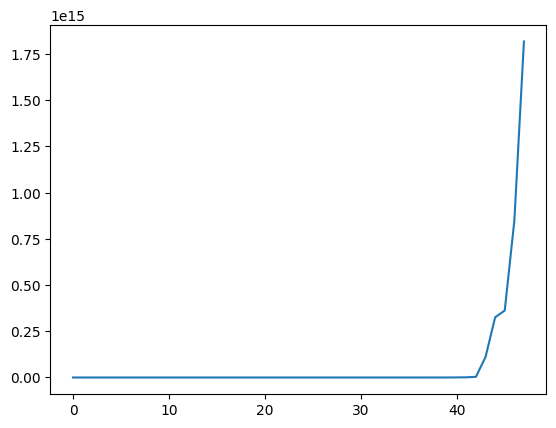

In [96]:
import matplotlib.pyplot as plt

plt.plot(tt)

In [97]:
tt2 = [tt[i]/tt[i-1] for i in range(1,len(tt))]

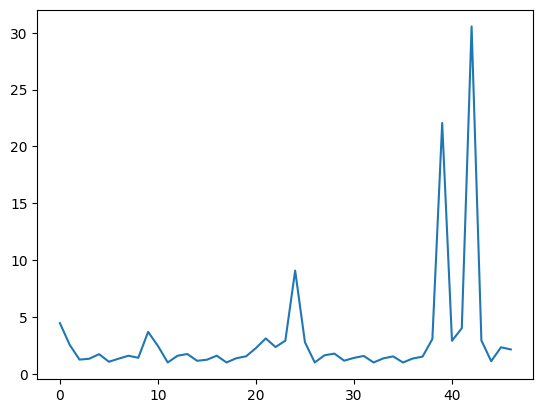

In [98]:
import matplotlib.pyplot as plt

plt.plot(tt2)